GBDT系のハイパラ探索用

In [ ]:
!pip install optuna catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/table_stan")
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from catboost import Pool
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import optuna

In [5]:
from sklearn.model_selection import KFold, train_test_split

data = pd.read_csv("data/train.csv")
X_sub = pd.read_csv("data/test.csv")
df_sub = pd.DataFrame({"id":np.arange(len(X_sub))})

In [62]:
target = "cost"
random_state = 13
test_size = 0.1
n_splits = 5
num_boost_round = 1000
stopping_rounds = 50
n_trials = 10
drop_columns = ["cost"]
model_name = "CatBoost"
cat_features = [6,7,10,11,12,13,14]
cat_features = ['recyclable_package', 'low_fat', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']

X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], test_size=test_size, random_state=random_state)
df_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1), columns=data.columns)
df_train[cat_features] = df_train[cat_features].astype(int)
df_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1), columns=data.columns)
df_test[cat_features] = df_test[cat_features].astype(int)
X_sub[cat_features] = X_sub[cat_features].astype(int)

In [50]:
display(df_train.head())
display(df_test.head())

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
26554,8.50,5.0,3.0,1.0,3.0,11.20,1,0,28.0,23598.0,0,0,0,0,1,101.84
37713,1.80,3.0,1.0,0.0,2.0,19.90,1,0,24.0,23759.0,1,0,1,1,1,89.90
32430,7.28,4.0,4.0,0.0,1.0,12.50,1,0,34.0,23759.0,1,0,1,1,1,89.90
28301,4.26,3.0,3.0,3.0,3.0,7.31,1,1,8.0,33858.0,1,0,1,1,1,136.74
1611,3.33,3.0,5.0,0.0,1.0,17.30,1,1,6.0,21215.0,1,0,0,0,0,135.80


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
30798,5.13,3.0,3.0,2.0,3.0,20.90,0,1,23.0,21215.0,1,0,0,0,0,123.88
44160,4.44,3.0,2.0,2.0,2.0,14.00,0,0,34.0,23598.0,0,0,0,0,1,122.51
25844,8.73,3.0,2.0,0.0,2.0,21.80,1,0,10.0,30797.0,1,1,1,1,1,76.88
48597,8.88,3.0,5.0,2.0,2.0,9.96,0,1,32.0,30584.0,1,1,1,1,1,86.79
10109,6.39,3.0,5.0,1.0,3.0,17.00,0,0,35.0,30268.0,0,0,0,0,0,98.52


In [56]:
def lgbm_objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "random_state": random_state,
        "verbose": -1,
        "learning_rate": 0.1,
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 300), 
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "max_bin" : trial.suggest_int("max_bin", 32, 512),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0), 
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 10), 
        "feature_fraction":  trial.suggest_float("feature_fraction", 0.1, 1.0), 
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-6, 500, log=True)
    }
    score = []
    for train_index, val_index in cv.split(df_train):
      y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
      X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
      y_val = df_train.iloc[val_index][target].to_numpy()
      X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
      data_train = lgb.Dataset(X_train, y_train)
      data_val = lgb.Dataset(X_val, y_val)
      
      # モデルを訓練する
      evals_result = {}
      model = lgb.train(
          param,
          train_set=data_train,
          valid_sets=[data_train, data_val],
          num_boost_round=num_boost_round,
          callbacks=[
              lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=False),
              lgb.record_evaluation(evals_result),
          ],
      )
      evals_results.append(evals_result)
      y_pred = np.expm1(model.predict(X_val))
      score.append(mean_squared_error(y_val, y_pred, squared=False))
    return -np.mean(score)

def xgb_objective(trial):
    param = {
        "objective": "reg:squarederror",
        "random_state": random_state,
        "learning_rate": 0.1,
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "max_delta_step": trial.suggest_float("max_delta_step", 0, 20),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100, log=True),
        "gamma": trial.suggest_float("gamma", 1e-9, 0.5, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1e-6, 500, log=True),
    }
    score = []
    for train_index, val_index in cv.split(df_train):
      y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
      X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
      y_val = df_train.iloc[val_index][target].to_numpy()
      X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()
      data_train = xgb.DMatrix(X_train, y_train)
      data_val = xgb.DMatrix(X_val, y_val)

      # モデルを訓練する
      evals_result = {}
      model = xgb.train(
          param,
          dtrain=data_train, 
          num_boost_round=num_boost_round,
          evals=[(data_train, "train"), (data_val, "val")],
          early_stopping_rounds=stopping_rounds,
          verbose_eval=False,
          evals_result=evals_result
      )
      evals_results.append(evals_result)
      y_pred = np.expm1(model.predict(data_val))
      score.append(mean_squared_error(y_val, y_pred, squared=False))
    return -np.mean(score)

def cat_objective(trial):
  param = {
      "iterations": num_boost_round,
      "loss_function":"RMSE",
      "random_state": random_state,
      "learning_rate": 0.1,
      "depth": trial.suggest_int("depth", 1, 8),
      "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
      "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
      "border_count": trial.suggest_int("border_count", 1, 255),
      "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 30),
  }
  score = []
  for train_index, val_index in cv.split(df_train):
    y_train = np.log1p(df_train.iloc[train_index][target])
    X_train = df_train.drop(drop_columns, axis=1).iloc[train_index]
    y_val = df_train.iloc[val_index][target]
    X_val = df_train.drop(drop_columns, axis=1).iloc[val_index]
    data_train = Pool(X_train, y_train,
                      cat_features=cat_features
                  )
    data_val = Pool(X_val,
                    cat_features=cat_features
                  )
    model = cat.CatBoostRegressor(**param)
    model.fit(data_train, 
              verbose_eval=False,
              early_stopping_rounds=stopping_rounds,
              )
    y_pred = np.expm1(model.predict(data_val))
    score.append(mean_squared_error(y_val, y_pred, squared=False))
  return -np.mean(score)

objective_dict = {
    "LightGBM" : lgbm_objective,
    "XGBoost" : xgb_objective,
    "CatBoost" : cat_objective
}

In [ ]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
evals_results = []

objective = objective_dict[model_name]
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

best_params = study.best_trial.params
best_score = study.best_trial.value

In [58]:
base_params_dict = {
    "LightGBM" : {
        "objective": "regression",
        "metric": "rmse",
        "random_state": random_state,
        "verbose": -1,
        },
    "XGBoost" : {
        "objective": "reg:squarederror",
        "random_state": random_state,
        "learning_rate": 0.1,
        },
    "CatBoost" : {
        "iterations": num_boost_round,
        "loss_function":"RMSE",
        "random_state": random_state,
        "learning_rate": 0.1,
      }
}

base_params = base_params_dict[model_name]

params = {**base_params, **study.best_trial.params}
print(params)
print(best_score)

{'iterations': 1000, 'loss_function': 'RMSE', 'random_state': 13, 'learning_rate': 0.1, 'depth': 3, 'random_strength': 8.217109086930845, 'bagging_temperature': 0.5813092713078705, 'border_count': 57, 'l2_leaf_reg': 14}
-29.531650441598437


In [66]:
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
models = []
evals_results = []
FEATURES = df_train.drop(drop_columns, axis=1).columns.tolist()
df_importance = pd.DataFrame(index=FEATURES)
df_preds = df_sub[["id"]].copy()

scores = []

for i, (train_index, val_index) in enumerate(cv.split(df_train)):
  print("=" * 20, f"START FOLD {i+1}", "=" * 20)
  y_train = np.log1p(df_train.iloc[train_index][target].to_numpy())
  X_train = df_train.drop(drop_columns, axis=1).iloc[train_index].to_numpy()
  y_val = df_train.iloc[val_index][target].to_numpy()
  X_val = df_train.drop(drop_columns, axis=1).iloc[val_index].to_numpy()

  if model_name=="LightGBM":
    data_train = lgb.Dataset(X_train, y_train)
    data_val = lgb.Dataset(X_val, y_val)
    data_sub = X_sub
    # 学習
    evals_result = {}
    model = lgb.train(
        params, train_set=data_train, valid_sets=[data_train, data_val], num_boost_round=num_boost_round,
        callbacks=[
            lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
            lgb.record_evaluation(evals_result),
        ],
    )
    models.append(model)
    # 特徴量重要度
    df_importance[f"FOLD_{i+1}"] = model.feature_importance(
        importance_type="gain"
    )
    # 検証データ
    y_pred = np.expm1(model.predict(X_val))
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    scores.append(rmsle)
    # 提出用データ
    pred = np.expm1(model.predict(X_sub))
    df_preds[f"pred_{i+1}"] = pred

  elif model_name == "XGBoost":
    data_train = xgb.DMatrix(X_train, y_train)
    data_val = xgb.DMatrix(X_val, y_val)
    data_sub = xgb.DMatrix(X_sub)
    evals_result = {}
    model = xgb.train(
        params, dtrain=data_train, num_boost_round=num_boost_round, evals=[(data_train, "train"), (data_val, "val")],
        early_stopping_rounds=stopping_rounds, verbose_eval=1000,
    )
    models.append(model)
    # 特徴量重要度
    z = model.get_score(importance_type="total_gain")
    zz = [z[f"f{i}"] if f"f{i}" in z else 0 for i in range(0, len(FEATURES))] # 重要度0は省略されるので追加しておく
    df_importance[f"FOLD_{i+1}"] = zz
    # 検証データ
    y_pred = np.expm1(model.predict(data_val))
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    scores.append(rmsle)
    # 提出用データ
    pred = np.expm1(model.predict(data_sub))
    df_preds[f"pred_{i+1}"] = pred

  elif model_name=="CatBoost":
    y_train = np.log1p(df_train.iloc[train_index][target])
    X_train = df_train.drop(drop_columns, axis=1).iloc[train_index]
    y_val = df_train.iloc[val_index][target]
    X_val = df_train.drop(drop_columns, axis=1).iloc[val_index]
    data_train = Pool(X_train, y_train,
                      cat_features=cat_features
                  )
    data_val = Pool(X_val,
                    cat_features=cat_features
                  )
    data_sub = Pool(X_sub,
                    cat_features=cat_features
                  )
    # 学習
    evals_result = {}
    model = cat.CatBoostRegressor(**params)
    model.fit(data_train, 
              verbose_eval=1000,
              early_stopping_rounds=stopping_rounds,
              )
    models.append(model)
    # 特徴量重要度
    df_importance[f"FOLD_{i+1}"] = model.get_feature_importance()
    # 検証データ
    y_pred = np.expm1(model.predict(data_val))
    rmsle = mean_squared_log_error(y_val, y_pred, squared=False)
    scores.append(rmsle)
    # 提出用データ
    pred = np.expm1(model.predict(data_sub))
    df_preds[f"pred_{i+1}"] = pred

  evals_results.append(evals_result)

==================== START FOLD 1 ====================
0:	learn: 0.3177242	total: 3.4ms	remaining: 3.4s
999:	learn: 0.3027027	total: 4.21s	remaining: 0us
==================== START FOLD 2 ====================
0:	learn: 0.3179158	total: 5.66ms	remaining: 5.66s
999:	learn: 0.3021802	total: 3.64s	remaining: 0us
==================== START FOLD 3 ====================
0:	learn: 0.3175493	total: 3.09ms	remaining: 3.09s
999:	learn: 0.3025587	total: 2.61s	remaining: 0us
==================== START FOLD 4 ====================
0:	learn: 0.3174127	total: 4.69ms	remaining: 4.68s
999:	learn: 0.3025097	total: 2.64s	remaining: 0us
==================== START FOLD 5 ====================
0:	learn: 0.3185130	total: 3.64ms	remaining: 3.64s
999:	learn: 0.3031016	total: 4.48s	remaining: 0us


In [67]:
print(f"Score mean: {np.mean(scores)}, Fold scores: {scores}")

Score mean: 0.3088056102830346, Fold scores: [0.30821469602007817, 0.31013868926026317, 0.3095877681530251, 0.30914555700380136, 0.30694134097800535]


In [68]:
df_preds[target] = df_preds.drop("id", axis=1).mean(axis=1)
print(df_train[target].min(), df_train[target].max())
print(df_preds[target].min(), df_preds[target].max())

50.79 149.75
72.73385172841304 127.02933145965987


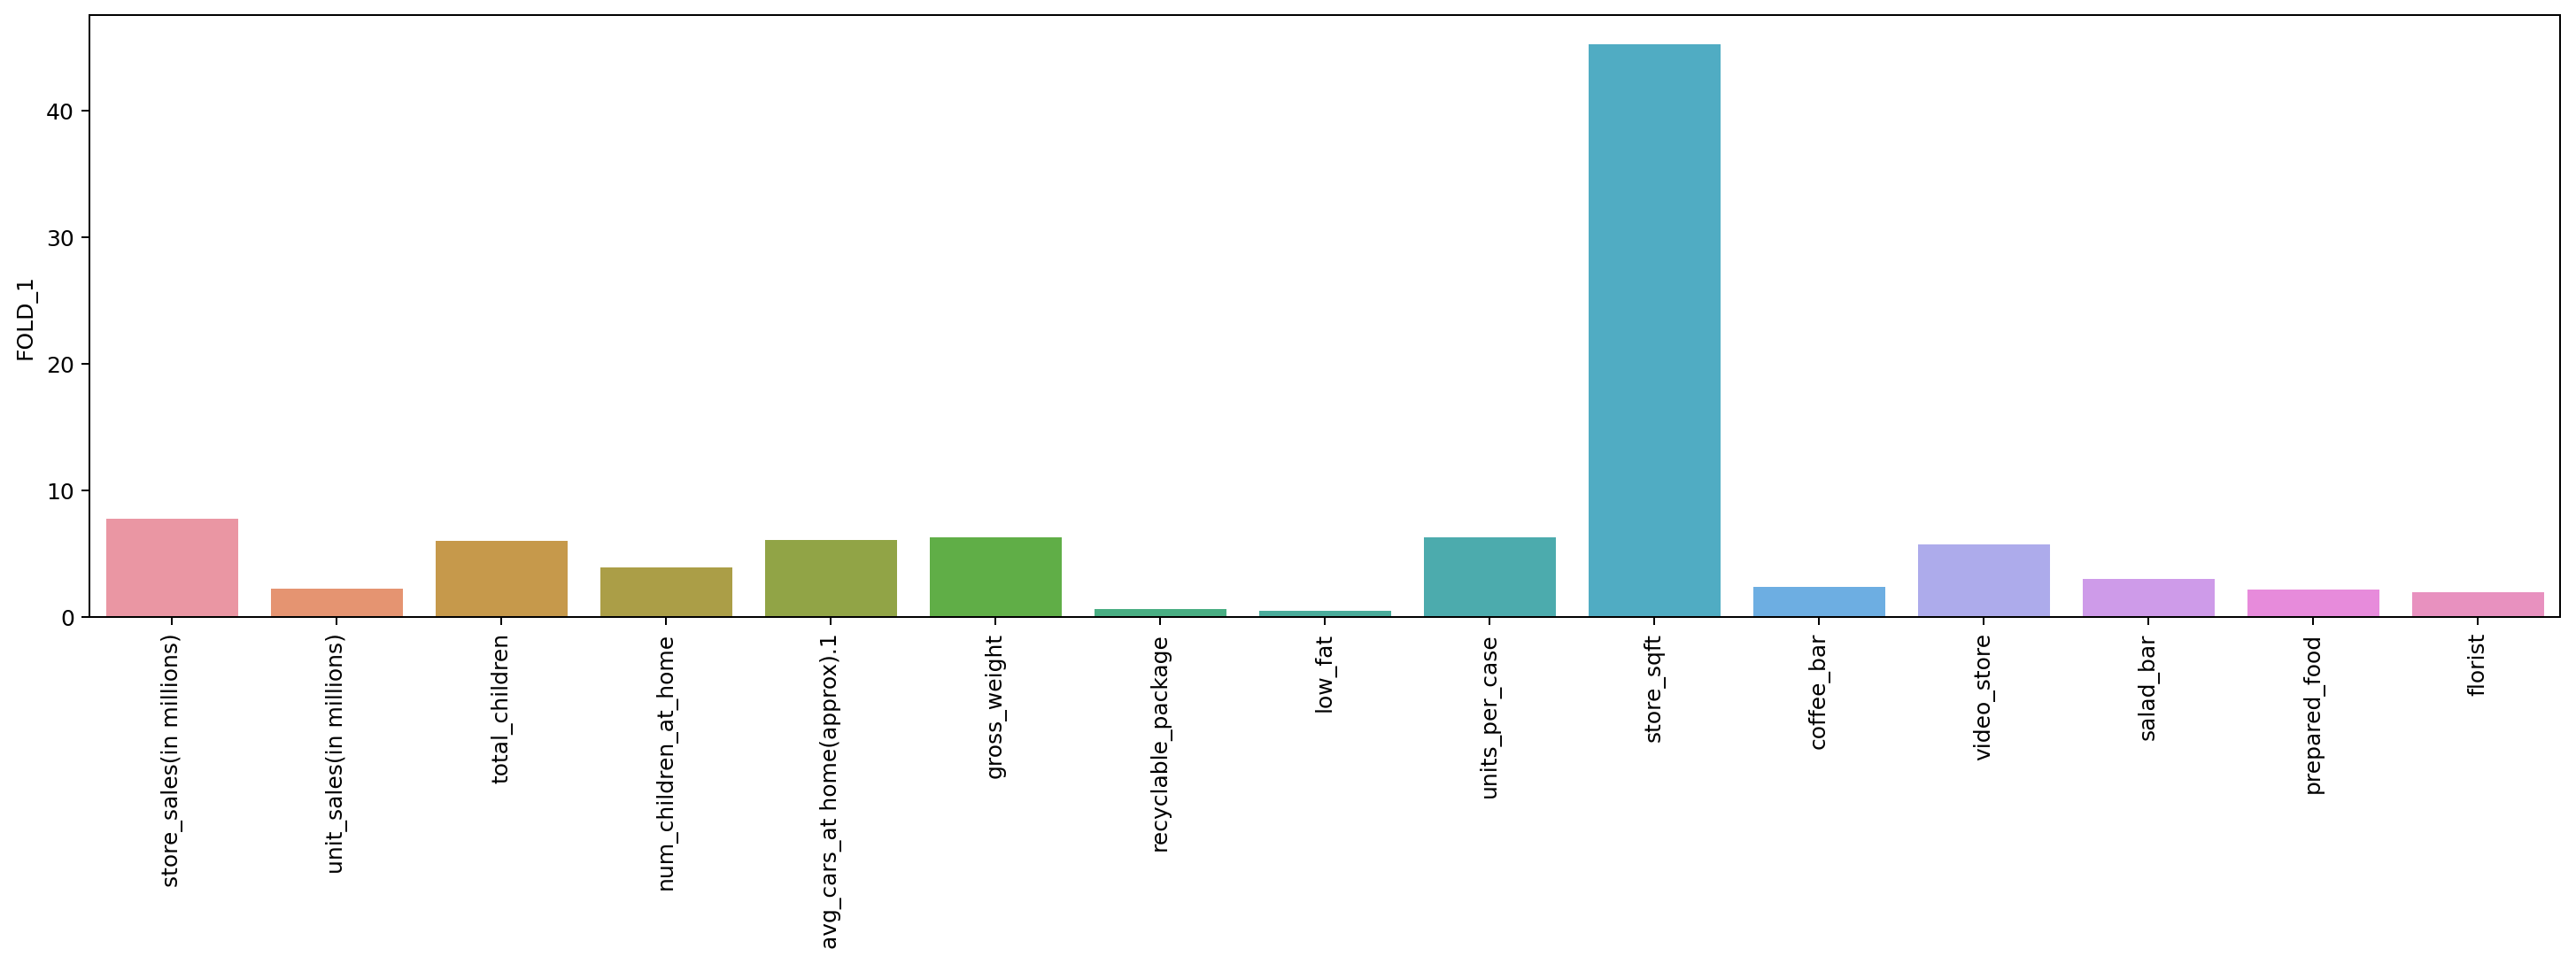

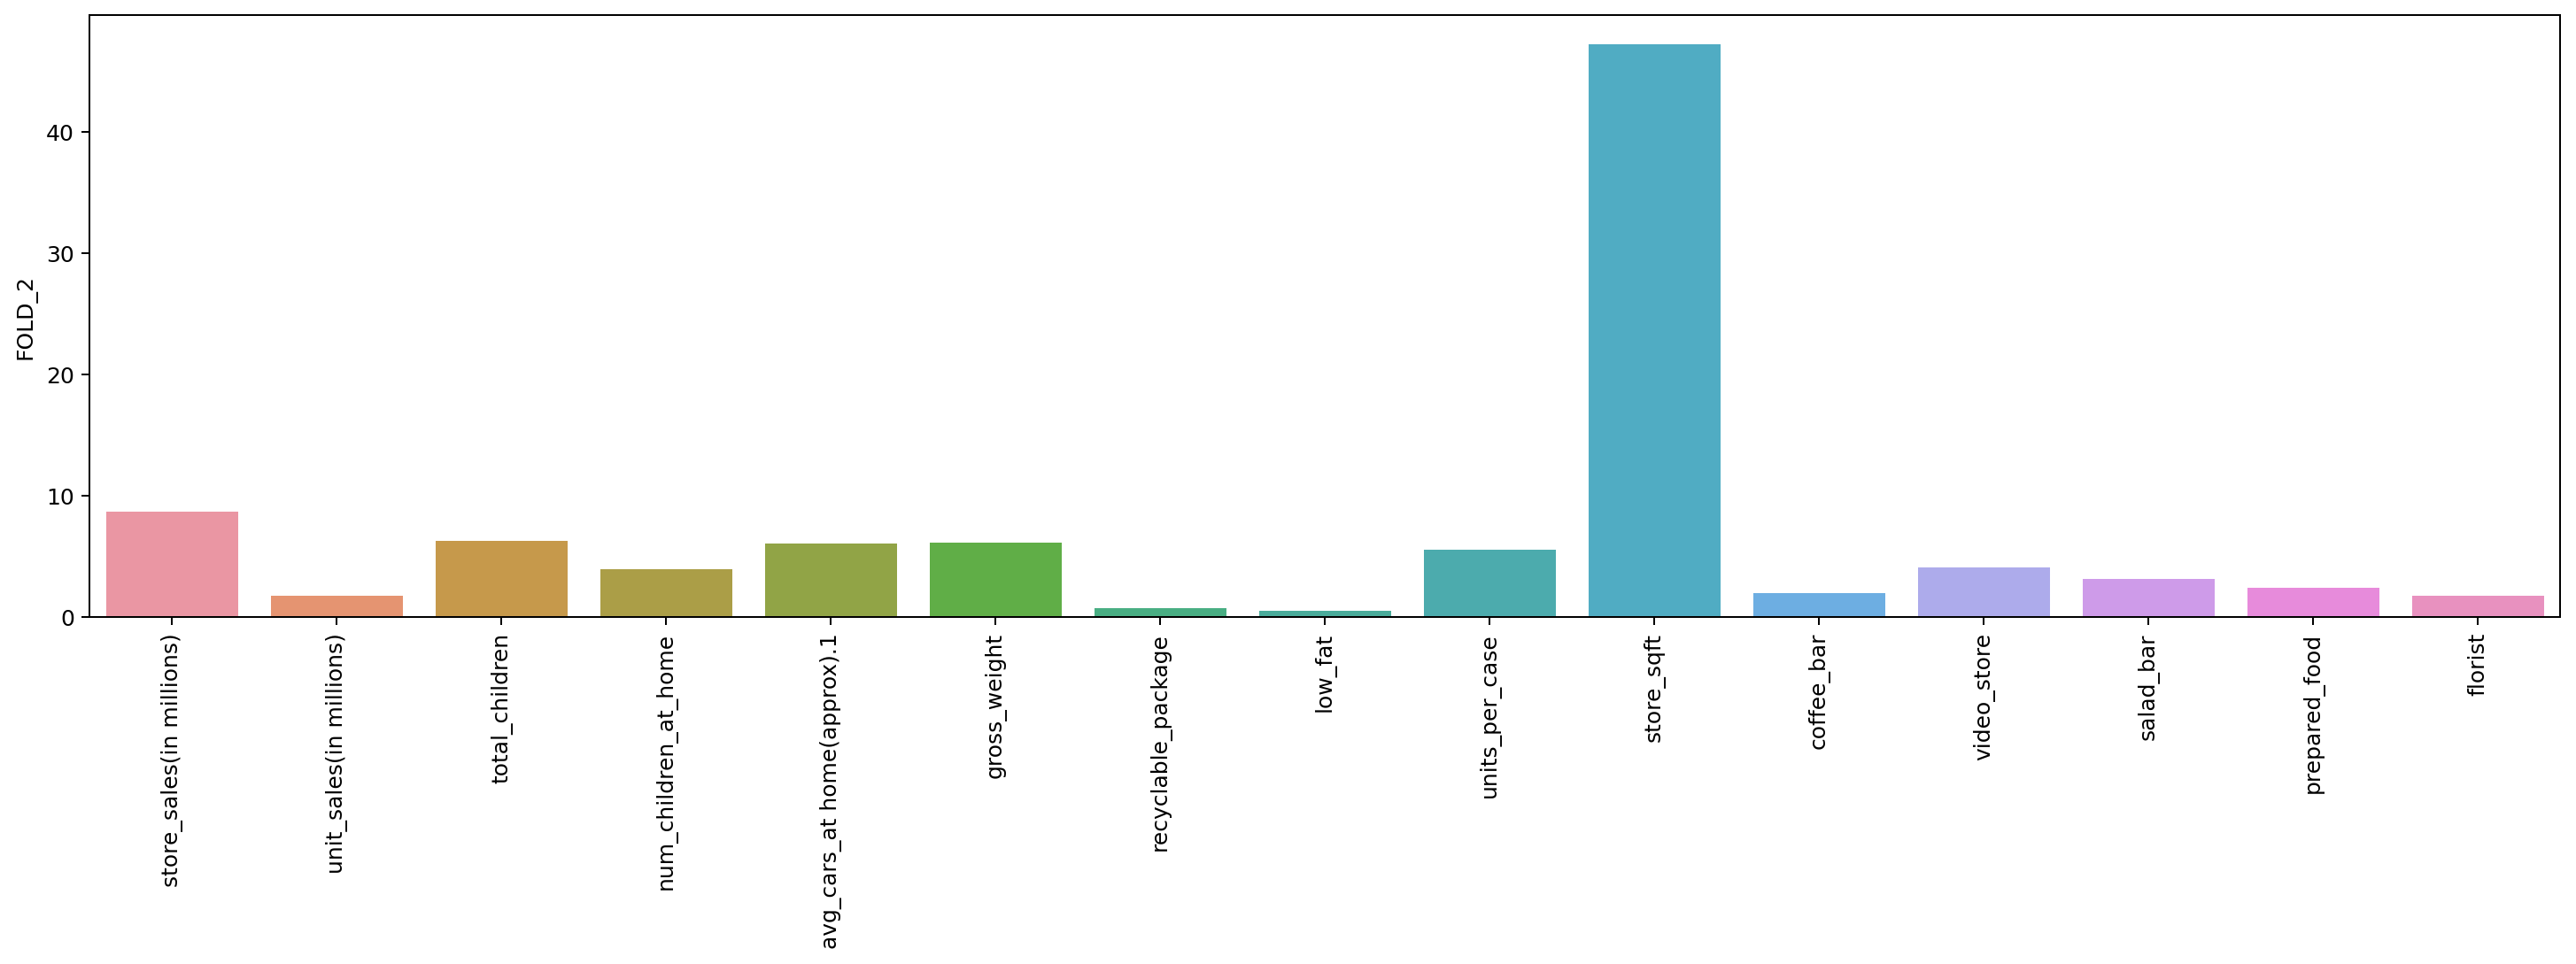

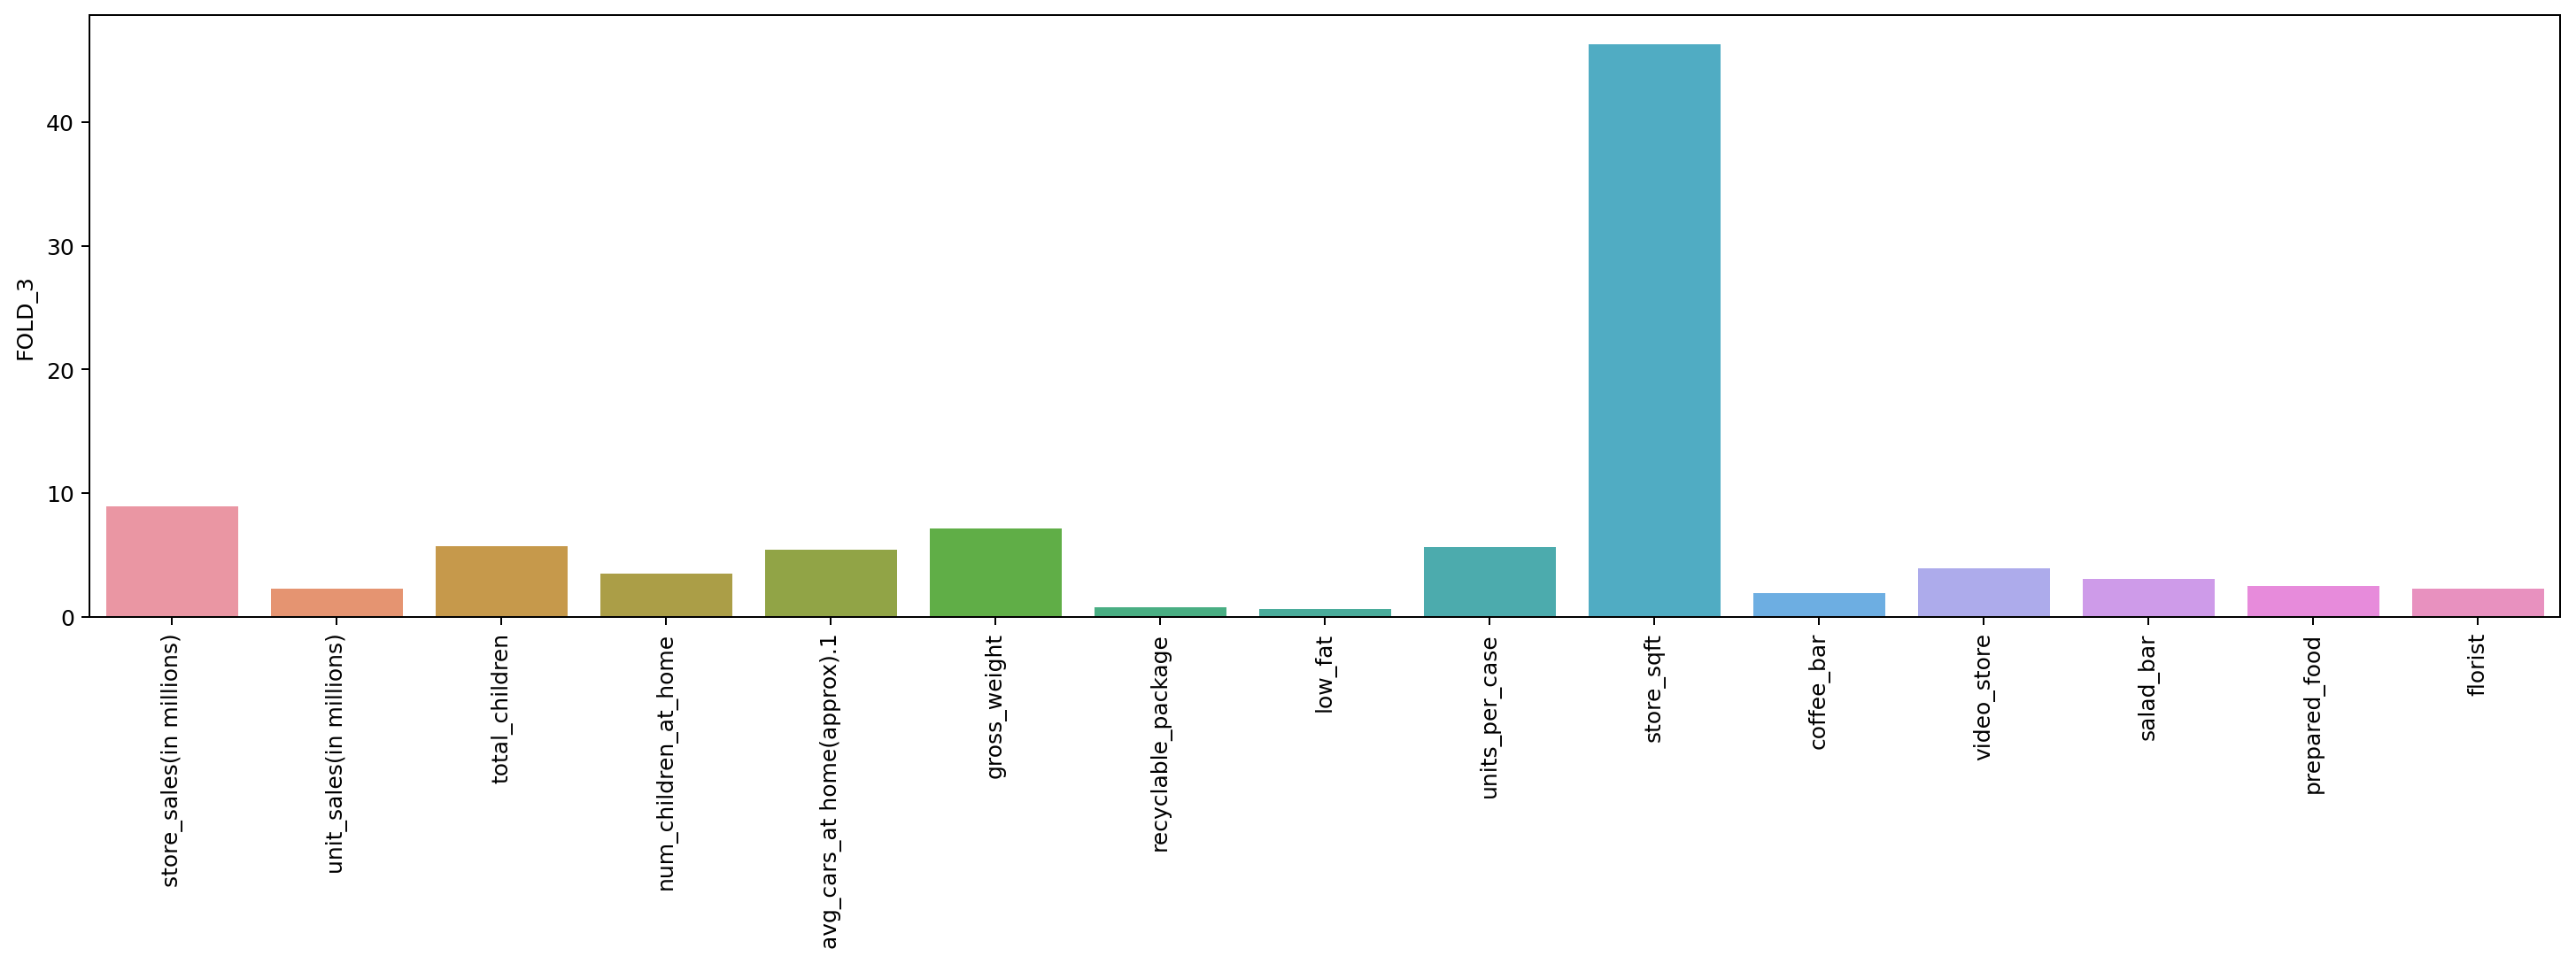

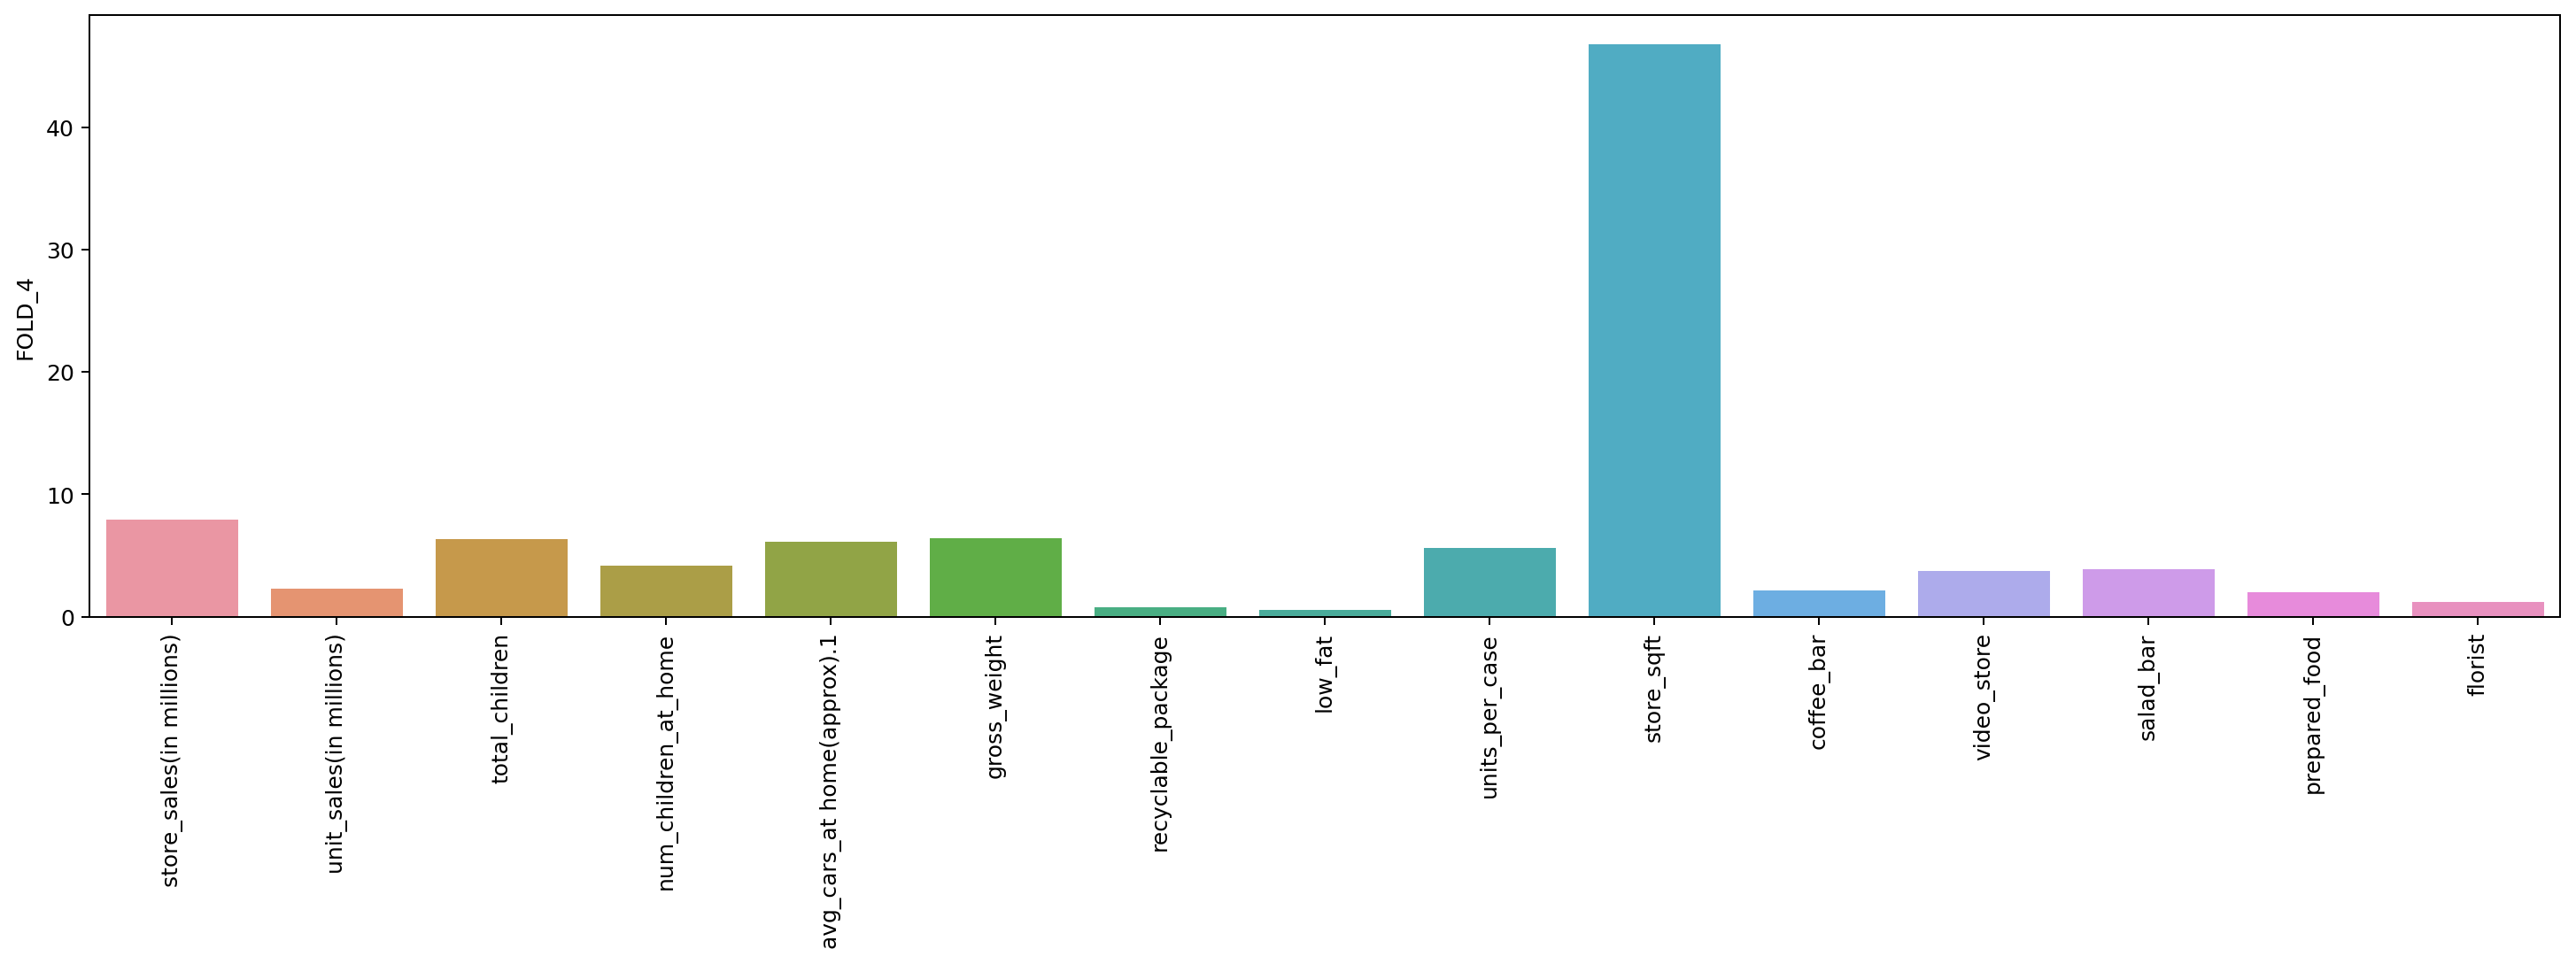

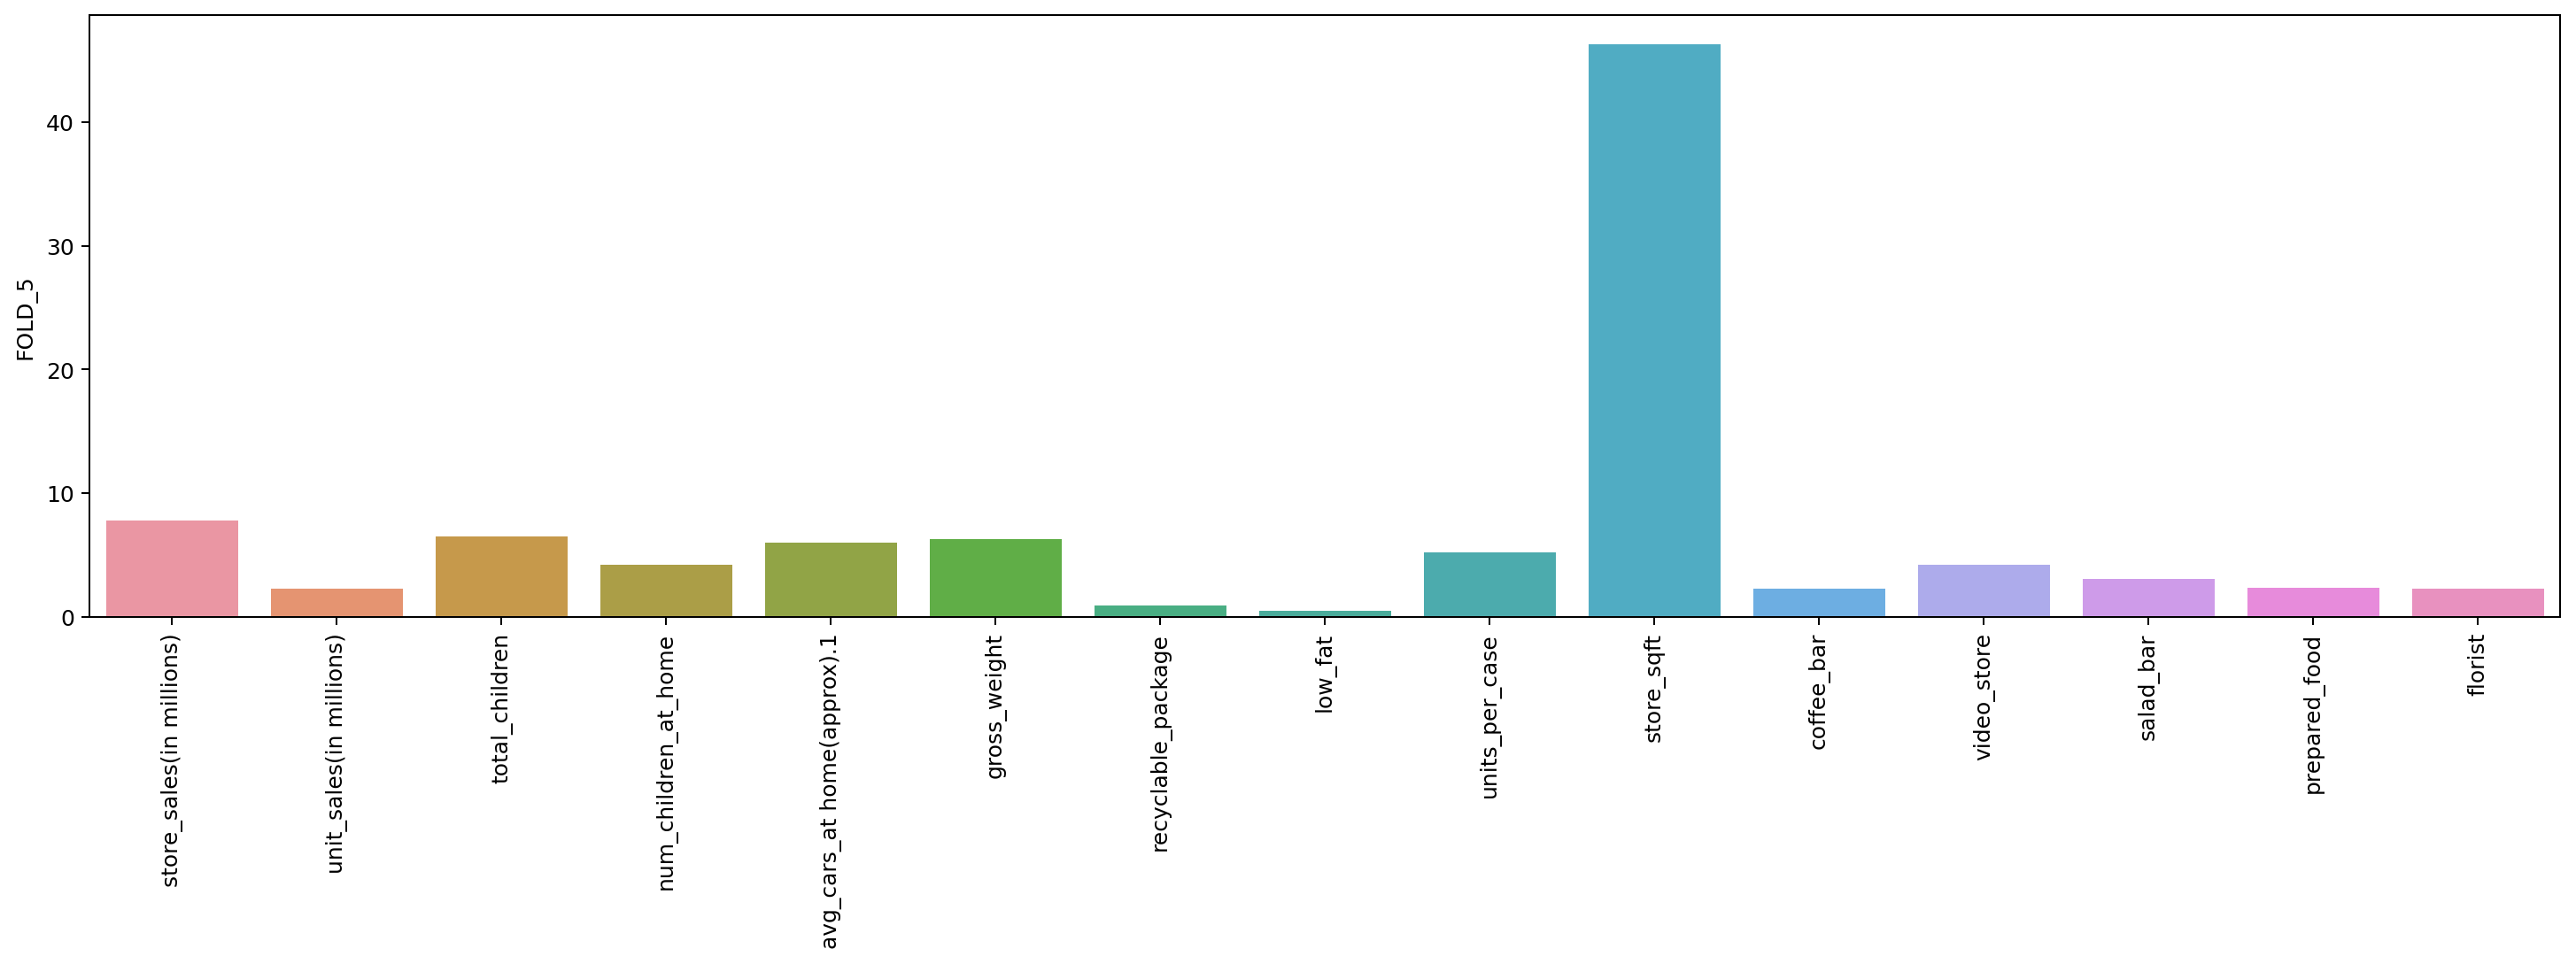

In [69]:
for col in df_importance.columns:
  fig = plt.figure(figsize=(20, 5), dpi=180)
  ax = fig.add_subplot(111)
  sns.barplot(x=df_importance.index, y=df_importance[col], ax=ax)
  plt.xticks(rotation=90)
  plt.show()

In [45]:
# now = datetime.now().astimezone(timezone('Asia/Tokyo'))

# submission = pd.read_csv("data/sample_submission.csv")
# submission["cost"] = df_preds["cost"].tolist()
# submission.to_csv(f"submissions/{now}-submission.csv", index=None)

In [46]:
# memo = ""

# pre = pd.read_csv("results/result.csv")
# df_result = pd.DataFrame([[now, "LightGBM", params, " ".join(FEATURES), np.mean(scores), , memo]])
# df_result.columns = ["date", "model", "params", "features", "val_RMSLE", "LB_RMSLE", "memo"]
# pd.concat([pre, df_result]).to_csv("results/result.csv", index=None)